# Stock data: Time-series vs. NLP vs. HMM vs. RNN

Just recenly talk with my friend on Whatsapp. He ask me about classification on time series data. At first I was confused about "classification on time series data". I thought that time series is just time series right? You do time series with time series model like ARIMA (that's the only model that I know). What do you mean by classification? And then I remember that actually I've seen the same problem on [Kaggle](https://www.kaggle.com/aaron7sun/stocknews). The problem of of the time series data is transformed into classication problem: the goal is to predict whether the today open index would be lower or higher than the today closing index. What is the predictor then? The predictor variables is news headlines from Reddit!

It's a binary classification problem with quite balanced target. But can we actually be able to predict the market with headline news? I heard that some financial institution and hedge fund actually use the news as one of their variables.

In this notebook, I want to try it. It is a good resource to learn more about time series and NLP classification problem. So let's go, starts with data description:

__Description:__

There are two channels of data provided in the dataset by the data contributor
1. News data: He crawled historical news headline from Reddit WorldNews Channel. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)
2. Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

He provided three data files in .csv format:
1. __RedditNews.csv__: two columns, the first column is the "date", and the second column is the "news headlines". All the news are ranked from top to bottom based on how hot they are. Hence, there are 25 lines for each date.
2. __DJIA_table.csv__: Downloaded direcly from [Yahoo Finance](https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI)
3. __Combined_News_DJIA.csv__: Combined 27 columns: The first column is date, the second is the label () and the rest is the top1 to top25 news headlines.

One note from data contributor:
> If you think you coded an amazing trading algorithm, friendly advice, do play safe with your own money :)

Since the data is small, I provided in this github too, you can look at it in `notebooks/data/stocknews`

In [312]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
djia = pd.read_csv('./data/stocknews/DJIA_table.csv')
djia.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [3]:
djia.shape

(1989, 7)

In [4]:
djia['Date'] = pd.to_datetime(djia['Date'], format="%Y-%m-%d")
djia_oc = djia[['Date', 'Open', 'Close']].set_index('Date')
djia_oc.head()

,Open,Close
Date,,
2016-07-01,17924.240234,17949.369141
2016-06-30,17712.759766,17929.990234
2016-06-29,17456.019531,17694.679688
2016-06-28,17190.509766,17409.720703
2016-06-27,17355.210938,17140.240234


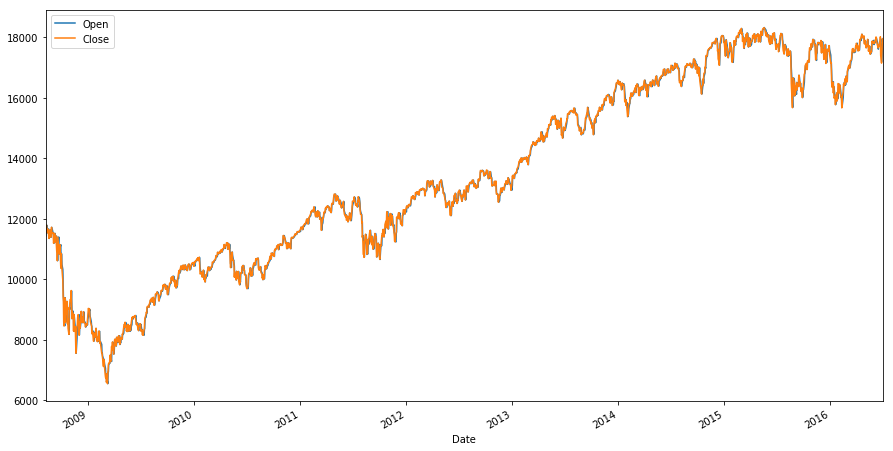

In [5]:
djia_oc.plot(figsize=(15,8))

A little bit intermeso, what is djia value actually? If you have ever play with sp500, this looks just the same.

Since it's about 7 years of daily data (about 2000 rows), we cannot see clearly how it's behave in daily basis. So let's plot a small range (30 days) data, staring from 2012-07-02.

In [6]:
start = pd.to_datetime('2012-07-02', format='%Y-%m-%d')
end = start + timedelta(days=30)
start

Timestamp('2012-07-02 00:00:00')

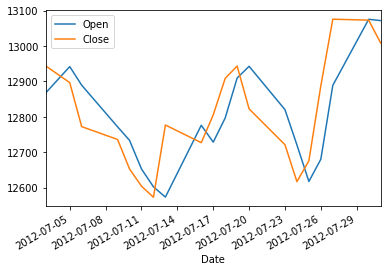

In [7]:
djia_oc[(djia_oc.index > start) & (djia_oc.index < end)].plot()

What a great sample for illustration. We can see that when the trends is going down, the close is lower than the open. When the trends is going up, the closing value is usually higher. But the most important thing is that how it seems have a simple pattern: that the trends continue to keep going down for several days and happen the same for up trends. It seems not completely random. If you have ever study about markov process/chain or __Hidden Markov Model__, this situation is quite the same: the probability of transition from up to up is higher that to down, and vice versa. To illustrate, if we give label of up to be 1 and down to be 0, the sequence of the above data would be like 11100000011111100000 something like that. But anyway, I've ever play with markov process and HMM before, but for never did that on time series data. Time series data like stock market might have some trends, and for now I don't know how to combine markov process and data with trends. So I'll leave it here for now.

## Reddit News

The second data is the Reddit news headlines. Let's see 

In [83]:
news = pd.read_csv('./data/stocknews/RedditNews.csv')
news['Date'] = pd.to_datetime(news['Date'], format='%Y-%m-%d')
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


Well, It just some usual news headlines.

In [84]:
news['News'].iloc[0]

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.'

In [85]:
news['News'].iloc[2]

'The president of France says if Brexit won, so can Donald Trump'

As preprocessing step, we can lower all the characters in the news, we can just user `lower()` in python to do that.

In [86]:
news['News'] = news['News'].map(lambda x: x.lower())
news.head()

,Date,News
0,2016-07-01,a 117-year-old woman in mexico city finally re...
1,2016-07-01,imf chief backs athens as permanent olympic host
2,2016-07-01,"the president of france says if brexit won, so..."
3,2016-07-01,british man who must give police 24 hours' not...
4,2016-07-01,100+ nobel laureates urge greenpeace to stop o...


I don't have experince about how some event in the world can affect the stock prices. For example the news about 117-year-old woman, nobody would think that would affect the market. Some news related to finance or politics might affect the market. So I think it is not a best practice to include all the news into consideration. 

If only we can classify the news according to it's topic and then do a sentiment analysis to the market. But that's the point isn't it? We can reverse the problem for training: determine a set of word feature maybe, like whether there are words like "crisis" in the list of headlines. That's the other solution of the problem that we may find: shed light on the types of information that are relevant to predicting the stock market movement.

But it's worth to explore, so here's the plan: Well, I dont' have a plan. Well I have but I'm not really sure it will be success.

1. Using fbprophet, we can get [trend changepoints](https://facebookincubator.github.io/prophet/docs/trend_changepoints.html) of the DJIA time series. We can extract those points and then manually examine the headlines for each those points. It won't be able to do something really useful tho, but at least we can get a better picture about the data. 
- The problem whit idea no.1 is that in this around 2000 daily data, it seems like we cannot see the movement on the daily basis. We did see the up and down in the data but the range might be on several days. It might be good if we try to see the headlines first and see the word "crisis" or some words that you think can affects price and plot the timeline alongside the DJIA. This is actualy would become bag of words model if we use all the available words. This model might actually find the representative words that can possibly affect the up and down in daily price. But I'm sure it's not that simple, ultimately for daily basis.
- There is an alternative to make the idea no.2 more feasible. We can resample the time to be weekly or even monthly basis. We will try to predict the label (up and down) in weekly of monthly basis instead of daily. We will get rid of markov model though.

Well, how to search the word crisis and find the datetime for that?

We can use python module for regex re

In [87]:
import re

In [88]:
def is_crisis(headline):
    if re.search('crisis', headline):
        return 1
    else:
        return 0

In [89]:
news['is_crisis'] = news['News'].map(is_crisis)

In [90]:
news.head()

,Date,News,is_crisis
0,2016-07-01,a 117-year-old woman in mexico city finally re...,0
1,2016-07-01,imf chief backs athens as permanent olympic host,0
2,2016-07-01,"the president of france says if brexit won, so...",0
3,2016-07-01,british man who must give police 24 hours' not...,0
4,2016-07-01,100+ nobel laureates urge greenpeace to stop o...,0


In [91]:
news[news['is_crisis'] == 1]

,Date,News,is_crisis
24,2016-07-01,ozone layer hole seems to be healing - us &amp...,1
282,2016-06-20,japan's dementia crisis hits record levels as ...,1
431,2016-06-14,leaked secret audio recordings of brazils most...,1
796,2016-05-31,migrant crisis is fueling sex trafficking of n...,1
842,2016-05-29,lufthansa suspends flights to venezuela amid t...,1
851,2016-05-28,zika crisis: rio olympics 'should be moved or ...,1
864,2016-05-28,brazil 'mass rape' video: president calls cris...,1
875,2016-05-27,thailand has shut down 10 popular diving sites...,1
999,2016-05-23,"across africa, the worst food crisis since 198...",1
1032,2016-05-21,'we are like a bomb': food riots show venezuel...,1


There are 647 headlines with word "crisis" in it out of 2000 times 25 number of headlines. And from a glimpse throug the headlines article that contains the word crisis above, we can see that the word crisis does always means a financial crisis. But anyway let's try it first

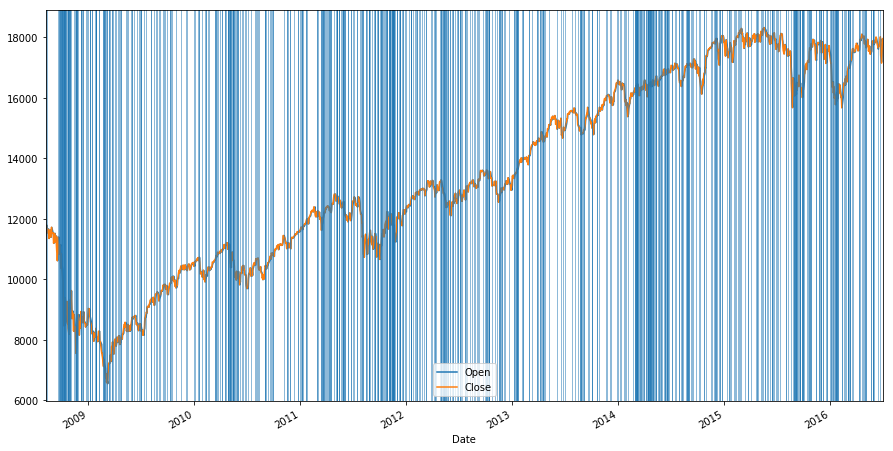

In [92]:
figure = djia_oc.plot(figsize=(15,8))
for date in news['Date'][news['is_crisis'] == 1]:
    plt.axvline(date, lw=1, alpha=0.5)

In [112]:
news = news.drop('is_crisis', axis=1)

Well some headlines with word "crisis" did appears but still doesn't show a clear insight if we're to make a conclusion about the word "crisis" with market price. They did appears as groups on several points in the timeline and some are appears in a sudden drops of price.

In [93]:
def is_word(headline, word):
    if re.search(word, headline):
        return 1
    else:
        return 0

def plot_word(word):
    dates = []
    for i in news.index:
        if is_word(news['News'][i], word):
            dates.append(news['Date'][i])
    #plot
    figure = djia_oc.plot(figsize=(15,8))
    for date in dates:
        plt.axvline(date, lw=1, alpha=0.5)

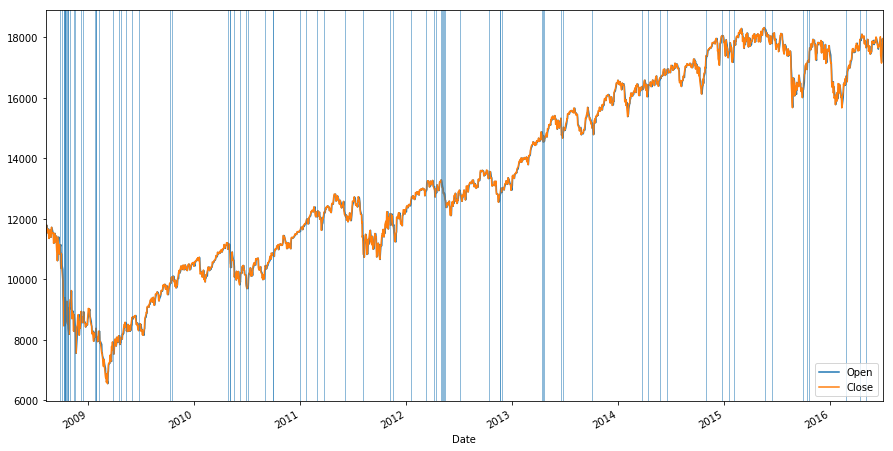

In [94]:
plot_word('financial crisis')

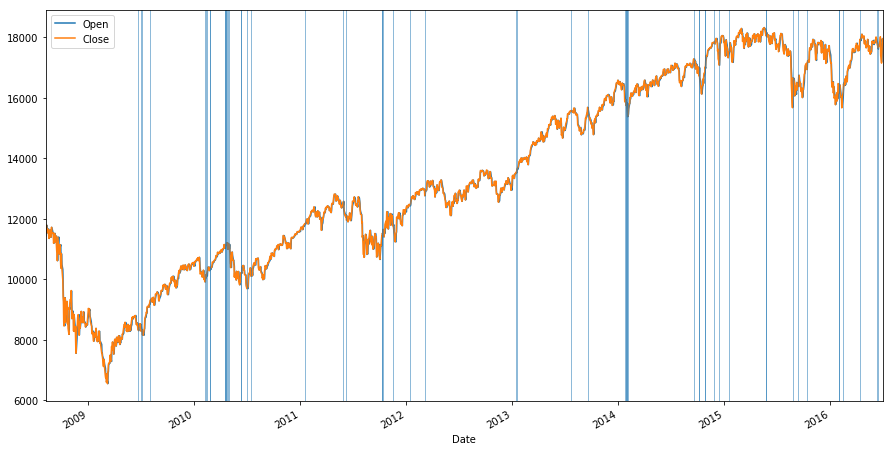

In [98]:
plot_word('goldman sachs')

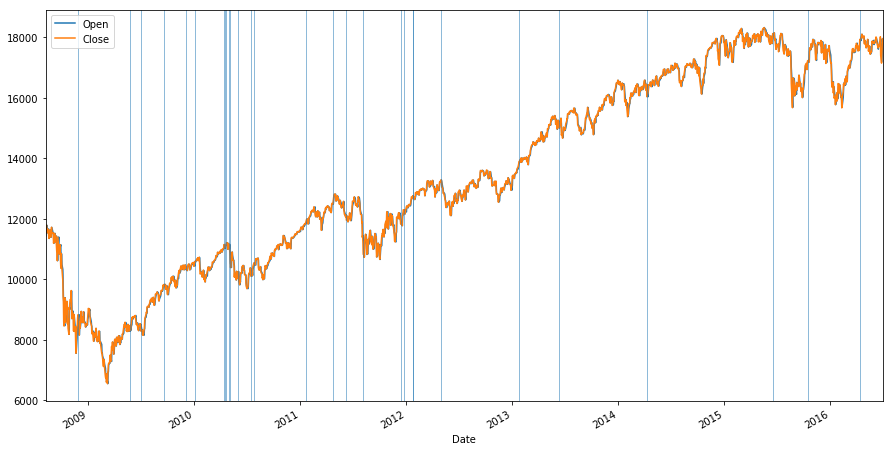

In [95]:
plot_word('bubble')

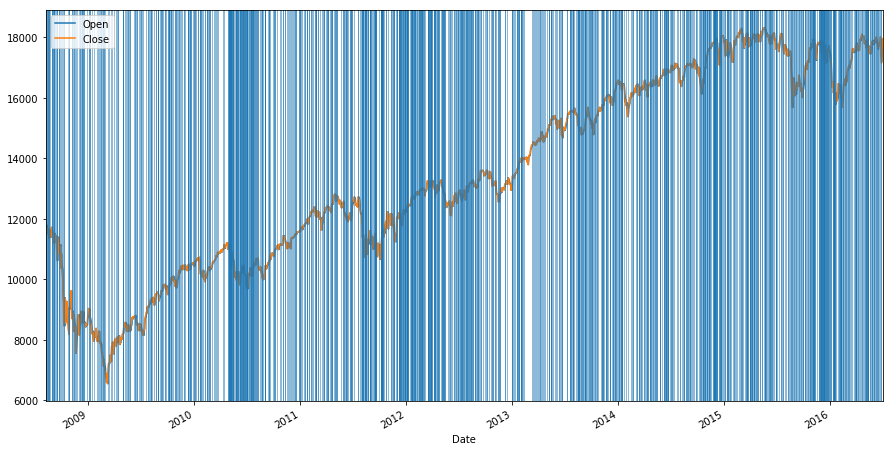

In [96]:
plot_word('oil')

Cannot do anything with this tho.

If we're going to use all the words in the news as features (with the values would be the counts how much that words appears in that day can it be called bag-of-words model? no idea), then I'm affraid that the feature would be to many. From this [kernel](https://www.kaggle.com/ndrewgele/omg-nlp-with-the-djia-and-reddit), there are total of 31,675 different words for all headlines, that would be 31,675 features.

But let's try that model. For that we will need to collect the news of each day into one row. It will be 25 news headline on each day. It will be just the same as the combined data. But let's do it ourself, it's a good way to practice data wrangling.

First, we will make label to djia data and make new dataframe with only the label and the date.

In [100]:
djia_l = djia.copy()
djia_l.head(2)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234


Well I always forget to do this apply() things, so gogol it

In [105]:
djia_l['label'] = djia_l[['Open', 'Close']].apply(lambda x: (1 if x['Open'] > x['Close'] else 0), axis=1)

In [211]:
djia_l = djia_l[['Date', 'label']]
djia_l.head()

,Date,label
0,2016-07-01,0
1,2016-06-30,0
2,2016-06-29,0
3,2016-06-28,0
4,2016-06-27,1


Then for the news dataframe, we need to combine those by date. For that I think we need to make a label first to our news dataframe so that we can use pivot table.

In [212]:
news_l = news.copy()
news_l.head()

,Date,News
0,2016-07-01,a 117-year-old woman in mexico city finally re...
1,2016-07-01,imf chief backs athens as permanent olympic host
2,2016-07-01,"the president of france says if brexit won, so..."
3,2016-07-01,british man who must give police 24 hours' not...
4,2016-07-01,100+ nobel laureates urge greenpeace to stop o...


In [213]:
labels = []
date_helper = news_l['Date'][0]
i = 0
for date in news_l['Date']:
    if date == date_helper:
        i = i+1
        labels.append('Top' + str(i))
    else:
        i = 1
        labels.append('Top' + str(i))
    date_helper = date

In [214]:
news_l['label_top'] = labels

In [215]:
news_l.head(10)

,Date,News,label_top
0,2016-07-01,a 117-year-old woman in mexico city finally re...,Top1
1,2016-07-01,imf chief backs athens as permanent olympic host,Top2
2,2016-07-01,"the president of france says if brexit won, so...",Top3
3,2016-07-01,british man who must give police 24 hours' not...,Top4
4,2016-07-01,100+ nobel laureates urge greenpeace to stop o...,Top5
5,2016-07-01,brazil: huge spike in number of police killing...,Top6
6,2016-07-01,austria's highest court annuls presidential el...,Top7
7,2016-07-01,"facebook wins privacy case, can track any belg...",Top8
8,2016-07-01,switzerland denies muslim girls citizenship af...,Top9
9,2016-07-01,china kills millions of innocent meditators fo...,Top10


Yeah, still stuck in data wrangling problem like this. Again man, a notes from me, put a high respect to the data wrangler in your office. I need to continue so I'll just used the combined data provided by the data contributor

In [216]:
df = pd.read_csv('./data/stocknews/Combined_News_DJIA.csv')
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [221]:
headLines = []
for i in range(df.shape[0]):
    headLines.append(' '.join(str(x) for x in df.iloc[i,2:27]))

In [222]:
headLines[0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\'

In [231]:
basicVectorizer = CountVectorizer()
count_word_matrix = basicVectorizer.fit_transform(headLines)

In [232]:
count_word_matrix.shape

(1989, 34708)

The `headLines` is a list of combined 25 headlines of each day. The `count_word_matrix` is our vector representation of each day. I mean, each day has a characteristics right? and that would be sparse vector of words with the value is the count of each words that appears on that day's headline. 

Here's a bit tutorial to illustrate bag-of-words model

In [290]:
x = pd.DataFrame({'day':[1,2], 'news':[
                                        'The dog eat the food!',
                                        'The cat eat the food\n'
                                      ]
                 })
x

,day,news
0,1,The dog eat the food!
1,2,The cat eat the food\n


In [291]:
x_vectorizer = CountVectorizer()

In [292]:
x_count_word_matrix = x_vectorizer.fit_transform(x['news'])
x_count_word_matrix

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [293]:
x_count_word_matrix.shape

(2, 5)

In [294]:
x_words = x_vectorizer.get_feature_names()
x_words

['cat', 'dog', 'eat', 'food', 'the']

In [295]:
x_count_word_df = pd.DataFrame(x_count_word_matrix.toarray())
x_count_word_df.columns = x_words
x_count_word_df

,cat,dog,eat,food,the
0,0,1,1,1,2
1,1,0,1,1,2


To see the resulting count word vector representation of each day (actually news in that day). We can merge it like this

In [296]:
z = pd.merge(x, x_count_word_df, left_index=True, right_index=True)
z

,day,news,cat,dog,eat,food,the
0,1,The dog eat the food!,0,1,1,1,2
1,2,The cat eat the food\n,1,0,1,1,2


As we can see, all the words has been lowered and some meaningless components has beed removed. The `CountVectorizer` actually has some parameters that we can try to examine, like: `stop_words` and `ngram_range`

In [298]:
x_vectorizer = CountVectorizer(stop_words='english')
x_count_word_matrix = x_vectorizer.fit_transform(x['news'])
x_words = x_vectorizer.get_feature_names()
x_count_word_df = pd.DataFrame(x_count_word_matrix.toarray())
x_count_word_df.columns = x_words
z = pd.merge(x, x_count_word_df, left_index=True, right_index=True)
z

,day,news,cat,dog,eat,food
0,1,The dog eat the food!,0,1,1,1
1,2,The cat eat the food\n,1,0,1,1


As we can see, the "the" dissapear from our feature column. Using `stop_words` we can exclude the stop words as our word feature. 

Let's try the `ngram_range` to see what can it do for us.

In [305]:
x_vectorizer = CountVectorizer(ngram_range=(1,2))
x_count_word_matrix = x_vectorizer.fit_transform(x['news'])
x_words = x_vectorizer.get_feature_names()
x_count_word_df = pd.DataFrame(x_count_word_matrix.toarray())
x_count_word_df.columns = x_words
z = pd.merge(x, x_count_word_df, left_index=True, right_index=True)
z

,day,news,cat,cat eat,dog,dog eat,eat,eat the,food,the,the cat,the dog,the food
0,1,The dog eat the food!,0,0,1,1,1,1,1,2,0,1,1
1,2,The cat eat the food\n,1,1,0,0,1,1,1,2,1,0,1


We get additional features that is n gram. It seems like it doesn't appear in a good order tho, but it doesn't matter. If you wonder what is n gram, that is just like the above data frame.

We will try that bag-of-words feature to predict the outcome of today's label

For a preliminary study, we not going to separate the data into train or test. We will just use the whole dataframe and see how it performs

In [309]:
df_try = df[['Label']]
df_try['docs'] = headLines
df_try.head()

/home/bimo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Label,docs
0,0,"b""Georgia 'downs two Russian warplanes' as cou..."
1,1,b'Why wont America and Nato help us? If they w...
2,0,b'Remember that adorable 9-year-old who sang a...
3,0,b' U.S. refuses Israel weapons to attack Iran:...
4,1,b'All the experts admit that we should legalis...


In [310]:
vectorizer = CountVectorizer(stop_words='english')
docs_bow = vectorizer.fit_transform(df_try['docs'])

In [311]:
docs_bow.shape

(1989, 34414)

Try using a simple Logistic Regression for classification task

In [313]:
model = LogisticRegression()
model.fit(docs_bow, df_try['Label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [314]:
model.score(docs_bow, df_try['Label'])

1.0

Well, I didn't thought it would be overfit really. Oh I see, lol. We have 1989 rows with 34,414 features! Of course it would be overfit!

As I said previously, we can use many models for this kind of problem. I have an idea to study NLP and sequential model to do this. But still doesn't know how. It seems like there is two part of sequential model
- There is transition probabilities between the label. The label at $t_0$ would be depend on the label at $t_{-1}$.
- And there is something else we going to take to model the outcome other than the previous label. That is the variables at $t_0$ itself. In our case, this would be variables that we can extract from the news in that day (bag of words features).

Let's explore Markov chain first. Let's say I have sequence of 2 labels (0,1) like this [000111000100010000]. How can I find the markov transition matrix? 

Do some google: https://stackoverflow.com/questions/25269476/python-transition-matrix

In [319]:
import numpy as np
from collections import Counter
a = [0,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,1]
b = np.zeros((2,2))
for (x, y), c in Counter(zip(a, a[1:])).items():
    b[x-1,y-1] = c
print(b)

[[ 11.   4.]
 [  5.   7.]]


Ya it works. But I need HMM and of course library lol, let's see:
- https://github.com/hmmlearn/hmmlearn: unsupervised learning and inference of HMM
- https://github.com/larsmans/seqlearn: supervised learning

But what is unsupervised and supervised in HMM?

## How about RNN?
The input will be the document feature, and the output will be the label. Why use RNN? There's always an assumption when you choose models. Yea the reason is when you know there's a sequential nature in the data

I've ever use RNN for:
- classify person's name
- generate person's name
- generate person's name conditioned to some class.

How can RNN model be used to generate something like that? In RNN:
- we give RNN a training sequence to learn and ask it to model the probability distribution of the next character in the sequence given a sequence of previous characters. In this case, we will train using $t$ as input and $t+1$ as output, that's it. Isn't it just the same as HMM. But HMM rely on markov assumption. RNN is not.
- How about RNN at the classification problem? iIn name classification: A character-level RNN reads words as a series of characters - outputing a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output.
- How about our problem?

Well turns out there's already some article about this man. Let's just read them!

https://bcourses.berkeley.edu/files/70257274/download

https://medium.com/@TalPerry/deep-learning-the-stock-market-df853d139e02